#### Integration of human fetal stem cells and mouse stem cells with `scVI` and `scANVI` pipeline
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 4th September 2024
- **Last modified date:** 4th September 2024

This notebook is created to integrate human gut fetal stem cells from Elementaite, 2021 dataset and mouse gut stem cells from Haber, 2017 study using `scVI` and `scANVI` tools, and then measure the quality of integration with `scIB` metrics. The orthologues derived from macrogenes identified with `SATURN` are used for genes. 

##### Import packages

In [11]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

##### Setup working environment

In [12]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [13]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [14]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [15]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Read in data

In [16]:
human_adata = sc.read_h5ad("data/Fetal_stem_cells_leiden.h5ad")

In [17]:
mouse_adata = sc.read_h5ad("data/Haber_2017_Smartseq_stem_cells_remapped.h5ad")

#### Create common set of genes

In [18]:
orthologues = pd.read_csv("data/saturn_results/macrogenes_derived_human_mouse_orthologues_10K.csv")

In [19]:
orthologues

Macrogene Top Human Gene Top Mouse Gene
0             0           PAK6           Pak4
1             1         PPFIA2         Ppfia4
2             2         TRIM71         Trim71
3             3          ETNK1           Chka
4             4       ANKRD36C         Bhlhb9
...         ...            ...            ...
9995       9995          KANK3          Kank3
9996       9996        SLC15A3        Slc15a4
9997       9997         MAP2K3           Nek6
9998       9998         CCDC14         Ccdc14
9999       9999       CDC42SE1       Cdc42se2

[10000 rows x 3 columns]

In [20]:
len(set(orthologues['Top Human Gene']).intersection(set(human_adata.var.index)))

6798

In [21]:
len(set(orthologues['Top Mouse Gene']).intersection(set(mouse_adata.var.index)))

6619

In [22]:
human_adata = human_adata[:, orthologues['Top Human Gene']]

In [23]:
human_adata.var.index.duplicated().sum()

3202

In [24]:
human_adata = human_adata[:, ~human_adata.var_names.duplicated()].copy()

+ remove dublicated genes from mouse dataset, leave genes that are expressed in more cells

In [25]:
mouse_adata.var.index.duplicated().sum()

175

In [26]:
mouse_adata = mouse_adata[:, ~mouse_adata.var_names.isin(['nan'])].copy()

In [27]:
mouse_adata = mouse_adata[:, ~mouse_adata.var_names.duplicated()].copy()

In [28]:
mouse_adata = mouse_adata[:, orthologues['Top Mouse Gene']]

In [29]:
mouse_adata.var['gene_name'] = mouse_adata.var.index

In [30]:
orthologues['Top Mouse Gene'].duplicated().sum()

3381

In [31]:
orthologues = orthologues[~orthologues['Top Mouse Gene'].duplicated()]

In [32]:
mouse_adata.var = mouse_adata.var.merge(orthologues, left_on = 'gene_name', right_on = 'Top Mouse Gene', how = 'left')

In [33]:
mouse_adata.var.index = mouse_adata.var['Top Human Gene']

In [34]:
mouse_adata.var.index.duplicated().sum()

5078

In [35]:
mouse_adata = mouse_adata[:, ~mouse_adata.var_names.duplicated()].copy()

+ Prepare obs

In [36]:
mouse_adata.obs['Library_Preparation_Protocol'] = 'Smart-seq2'
mouse_adata.obs['Sample_ID'] = mouse_adata.obs['Sample']
mouse_adata.obs['Study_name'] = 'Haber, 2017'


+ Concatenate datasets

In [37]:
adata = human_adata.concatenate(mouse_adata, batch_key = 'dataset', batch_categories = ['human', 'mouse'], join='inner', index_unique = None)

In [38]:
adata

AnnData object with n_obs × n_vars = 8306 × 4922
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'barcode', 'Gene_marker', 'GFP_intensity', 'full_cell_description', 'Sample'
    var: 'feature_types-0-0-0-human', 'gene_name-1-0-0-human', 'gene_id-0-0-human', 'GENE-1-0-human', 'n_counts-human', 'n_cells-human', 'n_counts-mouse', 'n_cells-mouse', 'ensemble_gene_id_version-mouse', 'ensemble_gene_id-mouse', 'start_position-mouse', 'end_position-mouse', 'chromosome_name-mouse', 'external_gene_name-mouse', 'gene_name-mouse', 'Macrogene-mouse', 'Top Human Gene-mouse', 'T

+ Run PCA

In [39]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:05)


In [40]:
adata.obs

Sample_ID   Cell Type  \
AAACCTGCATCTACGA-1-Human_colon_16S8159182  F72-FPIL-0-SC-1  Epithelial   
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182  F72-FPIL-0-SC-1  Epithelial   
AAACGGGTCTTACCGC-1-Human_colon_16S8159182  F72-FPIL-0-SC-1  Epithelial   
AAAGATGAGATATACG-1-Human_colon_16S8159182  F72-FPIL-0-SC-1  Epithelial   
AAAGATGGTCTCCATC-1-Human_colon_16S8159182  F72-FPIL-0-SC-1  Epithelial   
...                                                    ...         ...   
SRX2418923                                            S423         NaN   
SRX2418924                                            S424         NaN   
SRX2418925                                            S425         NaN   
SRX2418927                                            S427         NaN   
SRX2418929                                            S429         NaN   

                                                 Study_name Donor_ID  \
AAACCTGCATCTACGA-1-Human_colon_16S8159182  Elmentaite, 2021      F72   
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182  Elmentaite, 2021      F72   
AAACGGGTCTTACCGC-1-Human_colon_16S8159182  Elmentaite, 2021      F72   
AAAGATGAGATATACG-1-Human_colon_16S8159182  Elmentaite, 2021      F72   
AAAGATGGTCTCCATC-1-Human_colon_16S8159182  Elmentaite, 2021      F72   
...                                                     ...      ...   
SRX2418923                                      Haber, 2017       M5   
SRX2418924                                      Haber, 2017       M5   
SRX2418925                                      Haber, 2017       M5   
SRX2418927                                      Haber, 2017       M5   
SRX2418929                                      Haber, 2017       M5   

                                               Diagnosis   Age Region code  \
AAACCTGCATCTACGA-1-Human_colon_16S8159182  Fetal Healthy  16Wk        FPIL   
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182  Fetal Healthy  16Wk        FPIL   
AAACGGGTCTTACCGC-1-Human_colon_16S8159182  Fetal Healthy  16Wk        FPIL   
AAAGATGAGATATACG-1-Human_colon_16S8159182  Fetal Healthy  16Wk        FPIL   
AAAGATGGTCTCCATC-1-Human_colon_16S8159182  Fetal Healthy  16Wk        FPIL   
...                                                  ...   ...         ...   
SRX2418923                                           NaN   NaN         NaN   
SRX2418924                                           NaN   NaN         NaN   
SRX2418925                                           NaN   NaN         NaN   
SRX2418927                                           NaN   NaN         NaN   
SRX2418929                                           NaN   NaN         NaN   

                                          Fraction     Sex  \
AAACCTGCATCTACGA-1-Human_colon_16S8159182       SC  Female   
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182       SC  Female   
AAACGGGTCTTACCGC-1-Human_colon_16S8159182       SC  Female   
AAAGATGAGATATACG-1-Human_colon_16S8159182       SC  Female   
AAAGATGGTCTCCATC-1-Human_colon_16S8159182       SC  Female   
...                                            ...     ...   
SRX2418923                                     NaN     NaN   
SRX2418924                                     NaN     NaN   
SRX2418925                                     NaN     NaN   
SRX2418927                                     NaN     NaN   
SRX2418929                                     NaN     NaN   

                                          Library_Preparation_Protocol  ...  \
AAACCTGCATCTACGA-1-Human_colon_16S8159182                    10x 5' v1  ...   
AAACGGGTCGGCGCAT-1-Human_colon_16S8159182                    10x 5' v1  ...   
AAACGGGTCTTACCGC-1-Human_colon_16S8159182                    10x 5' v1  ...   
AAAGATGAGATATACG-1-Human_colon_16S8159182                    10x 5' v1  ...   
AAAGATGGTCTCCATC-1-Human_colon_16S8159182                    10x 5' v1  ...   
...                                                                ...  ...   
SRX2418923                                                  

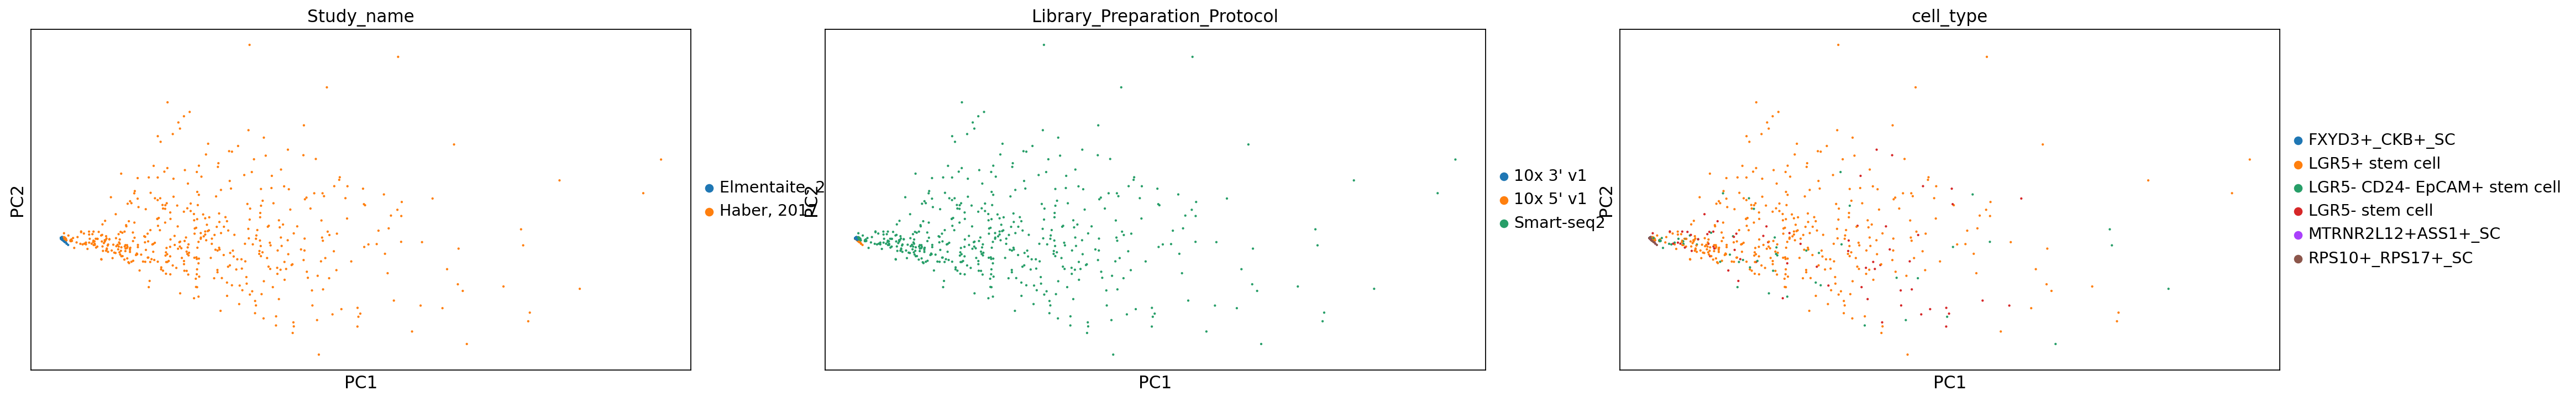

In [41]:
sc.set_figure_params(figsize=(10,5))
sc.pl.pca(adata,color=["Study_name", "Library_Preparation_Protocol", "cell_type"])

#### Run scVI

In [42]:
adata.layers['counts'] = adata.X.copy()

In [43]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Library_Preparation_Protocol'],
                              continuous_covariate_keys=['n_counts', 'n_genes'],
                              labels_key = "cell_type", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [44]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [45]:
scvi_model.train(40, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 40/40: 100%|█| 40/40 [00:22<00:00,  1.85it/s, v_num=1, train_loss_step=2.82e+3, train_loss_ep

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|█| 40/40 [00:22<00:00,  1.76it/s, v_num=1, train_loss_step=2.82e+3, train_loss_ep


In [46]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

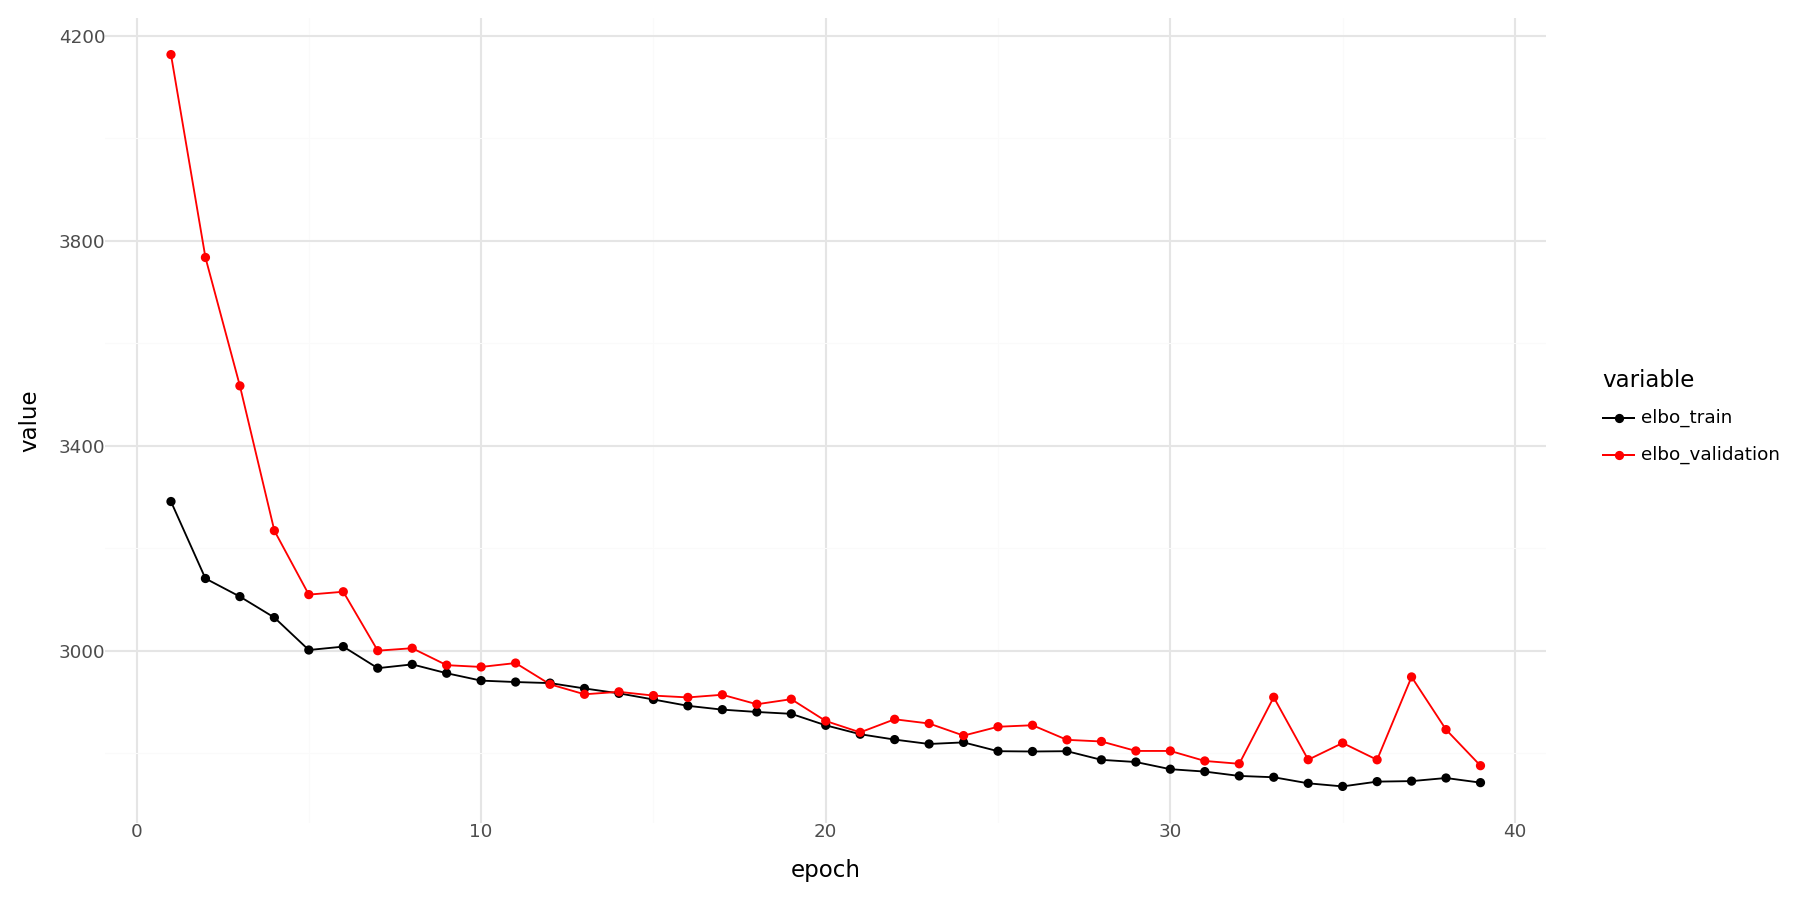

In [47]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [65]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [66]:
scanvi_model.train(300, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 300 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 300/300: 100%|█| 300/300 [07:34<00:00,  1.49s/it, v_num=1, train_loss_step=2.39e+3, train_los

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|█| 300/300 [07:34<00:00,  1.52s/it, v_num=1, train_loss_step=2.39e+3, train_los


In [67]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [68]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

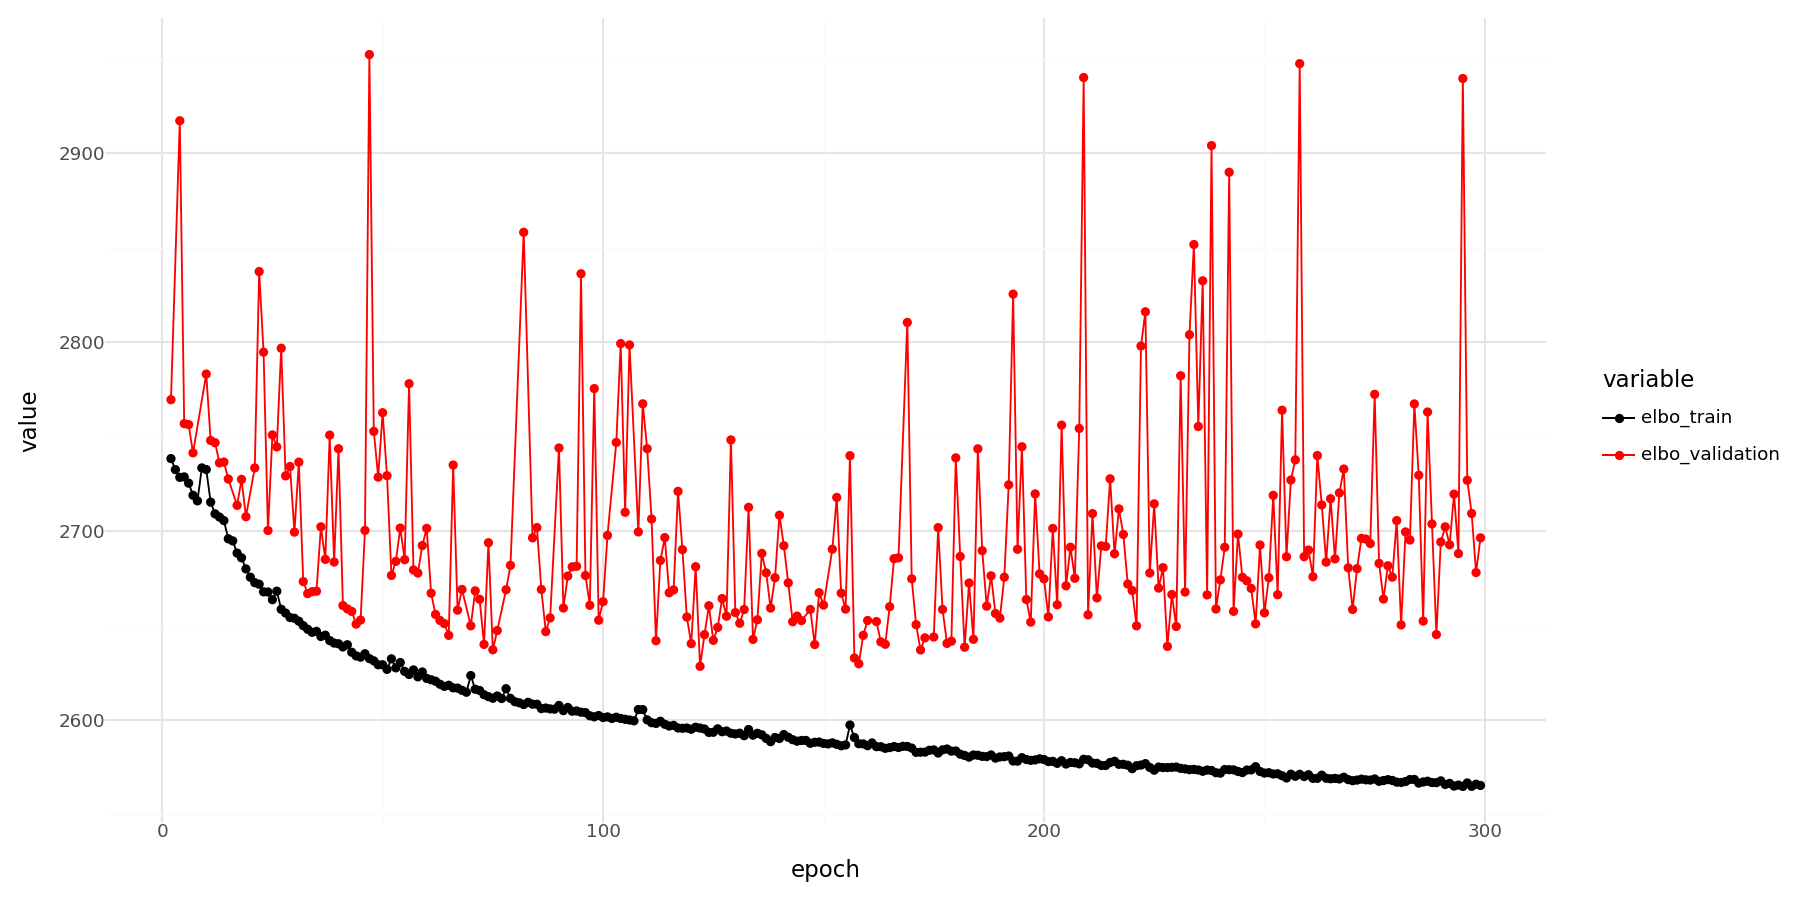

In [73]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars=['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x='epoch', y='value', color='variable'), 
             history_df.query('epoch > 1 & value < 3000'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

+ Visualize dataset

In [74]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


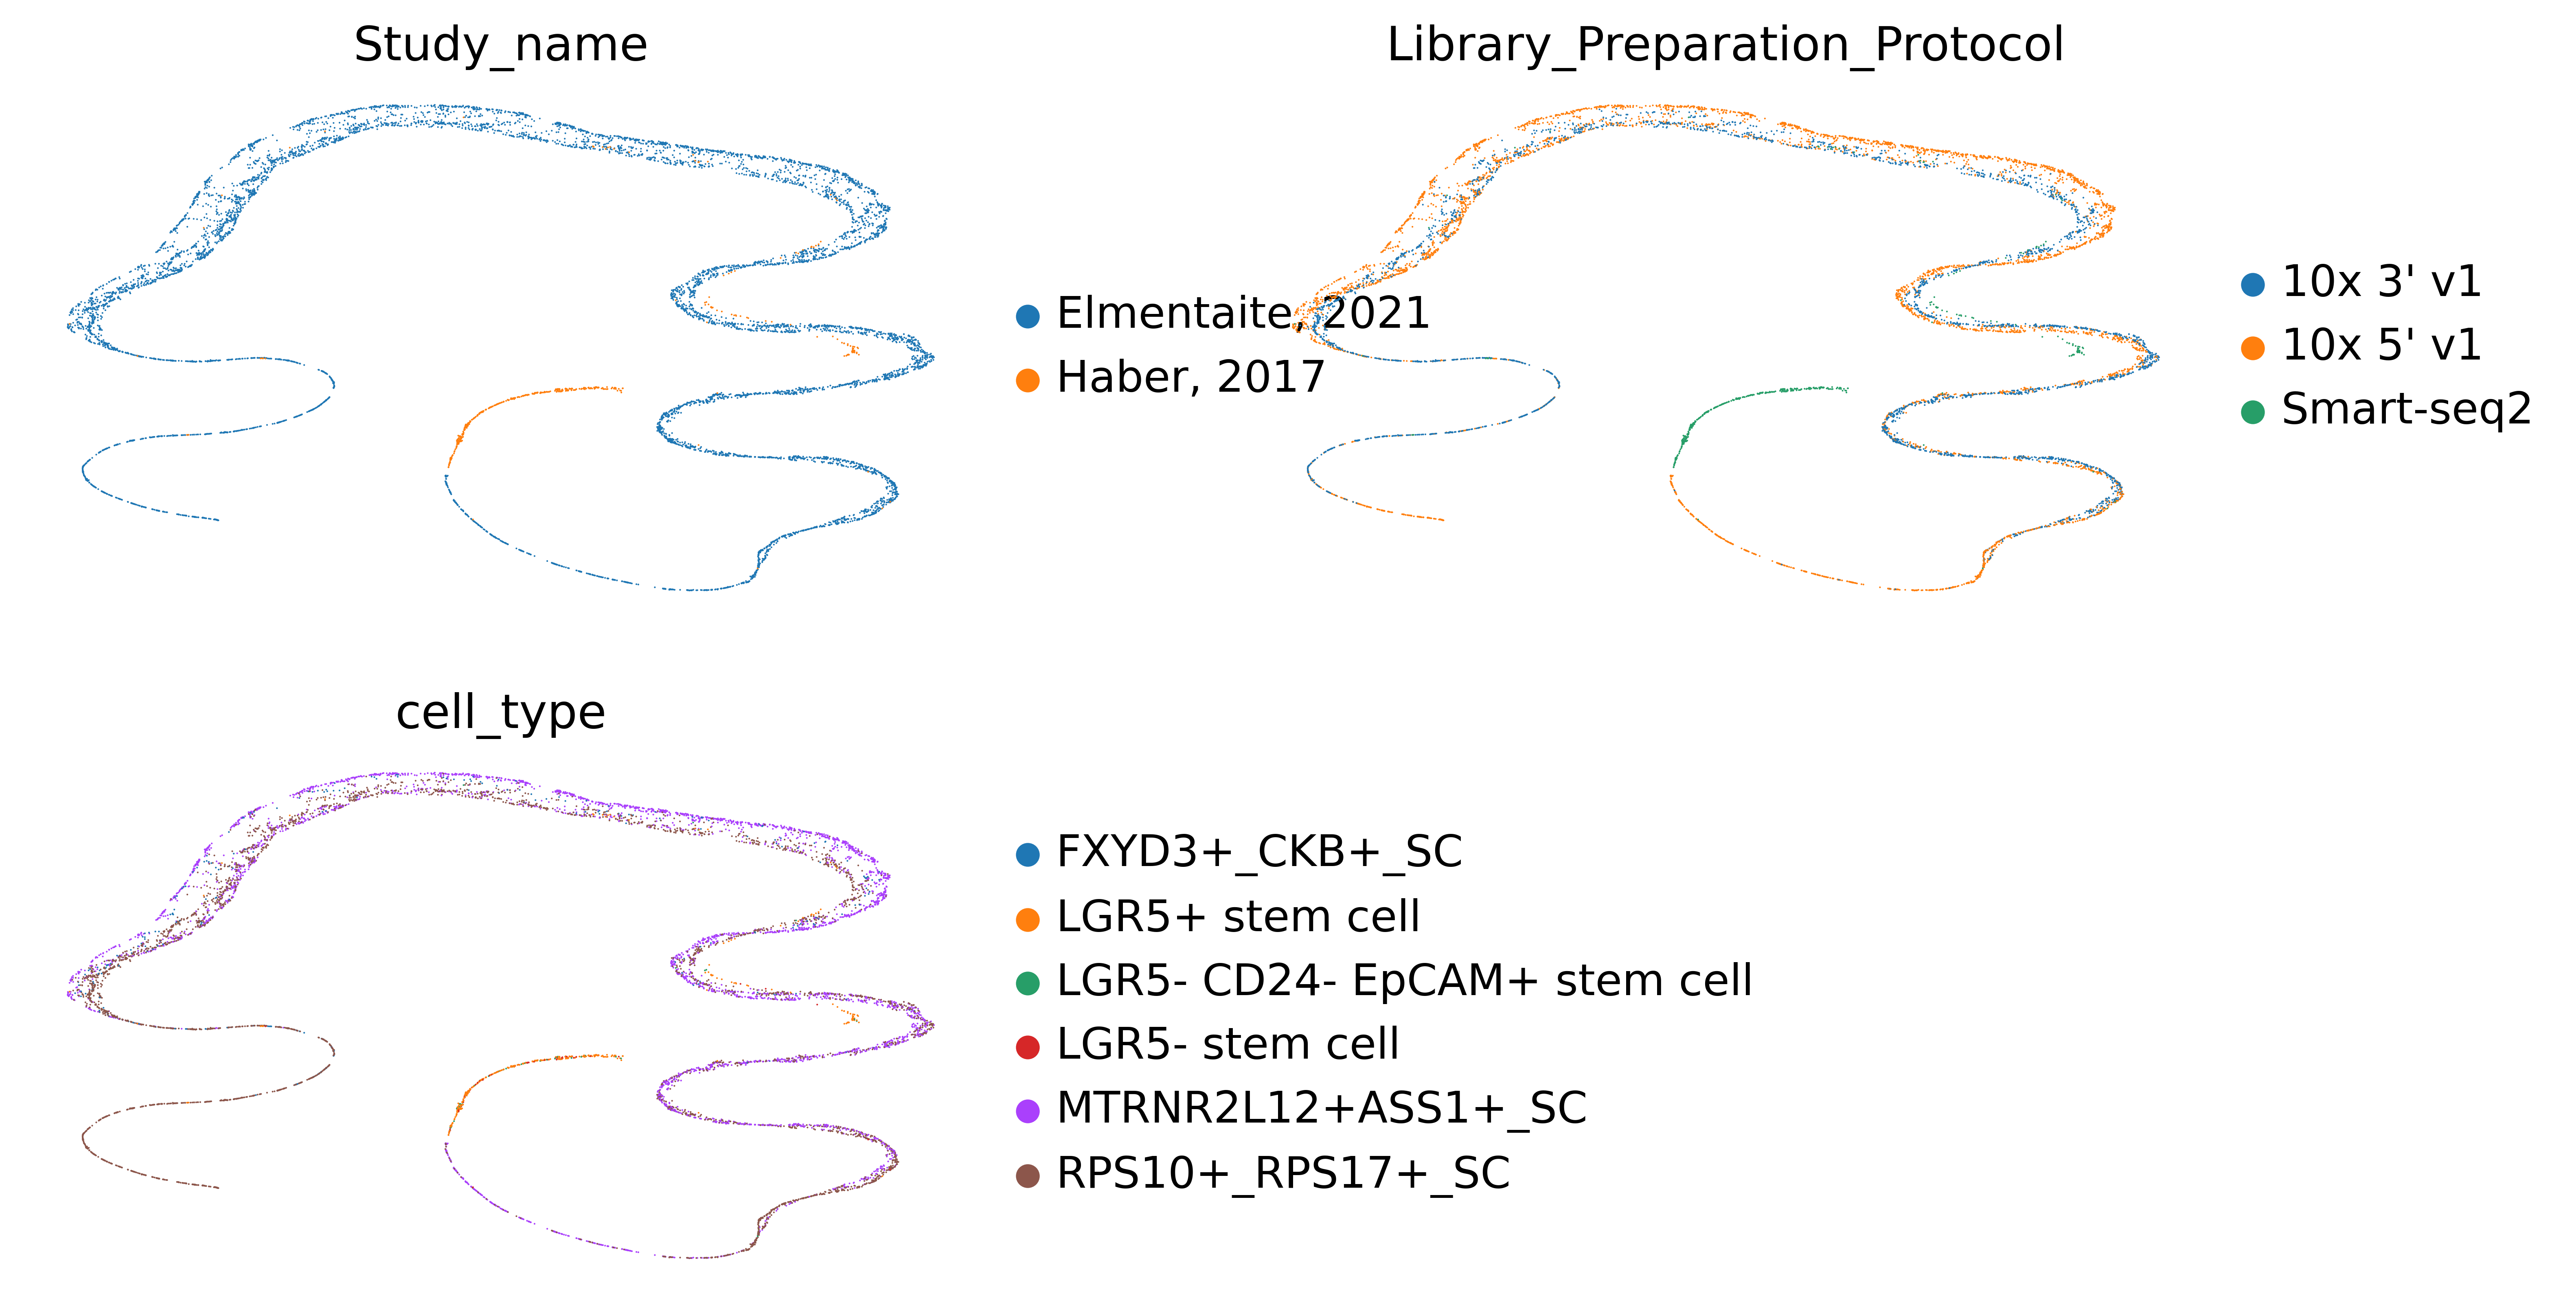

In [75]:
sc.set_figure_params(dpi = 300, figsize=(5,3))
sc.pl.umap(adata, color = ["Study_name", "Library_Preparation_Protocol", "cell_type"], ncols = 2, frameon = False, size = 1)

+ Check scIB metrics

In [56]:
SATRUN_adata = sc.read_h5ad("data/saturn_results/saturn_results/test256_data_FetalSC_for_SATURN_Haber_2017_Smartseq_stem_cells_remapped_org_saturn_seed_0.h5ad")

In [57]:
SATRUN_adata

AnnData object with n_obs × n_vars = 8306 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species'
    uns: 'labels2_colors', 'neighbors', 'pca', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_saturn', 'X_umap', 'macrogenes'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [58]:
adata.obsm['X_saturn'] = SATRUN_adata.obsm['X_saturn'].copy()

In [59]:
adata

AnnData object with n_obs × n_vars = 8306 × 4922
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'barcode', 'Gene_marker', 'GFP_intensity', 'full_cell_description', 'Sample', 'C_scANVI'
    var: 'feature_types-0-0-0-human', 'gene_name-1-0-0-human', 'gene_id-0-0-human', 'GENE-1-0-human', 'n_counts-human', 'n_cells-human', 'n_counts-mouse', 'n_cells-mouse', 'ensemble_gene_id_version-mouse', 'ensemble_gene_id-mouse', 'start_position-mouse', 'end_position-mouse', 'chromosome_name-mouse', 'external_gene_name-mouse', 'gene_name-mouse', 'Macrogene-mouse', 'Top Human Gen

computing PCA
    with n_comps=50


    finished (0:00:02)


Embeddings:   0%|                                                            | 0/4 [00:00<?, ?it/s]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  25%|█████████████                                       | 1/4 [00:16<00:50, 16.79s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  50%|██████████████████████████                          | 2/4 [00:31<00:31, 15.66s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings:  75%|███████████████████████████████████████             | 3/4 [00:43<00:13, 13.70s/it]

INFO     LGR5+ stem cell consists of a single batch or is too small. Skip.                                         
INFO     LGR5- CD24- EpCAM+ stem cell consists of a single batch or is too small. Skip.                            
INFO     LGR5- stem cell consists of a single batch or is too small. Skip.                                         


Embeddings: 100%|████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.31s/it]


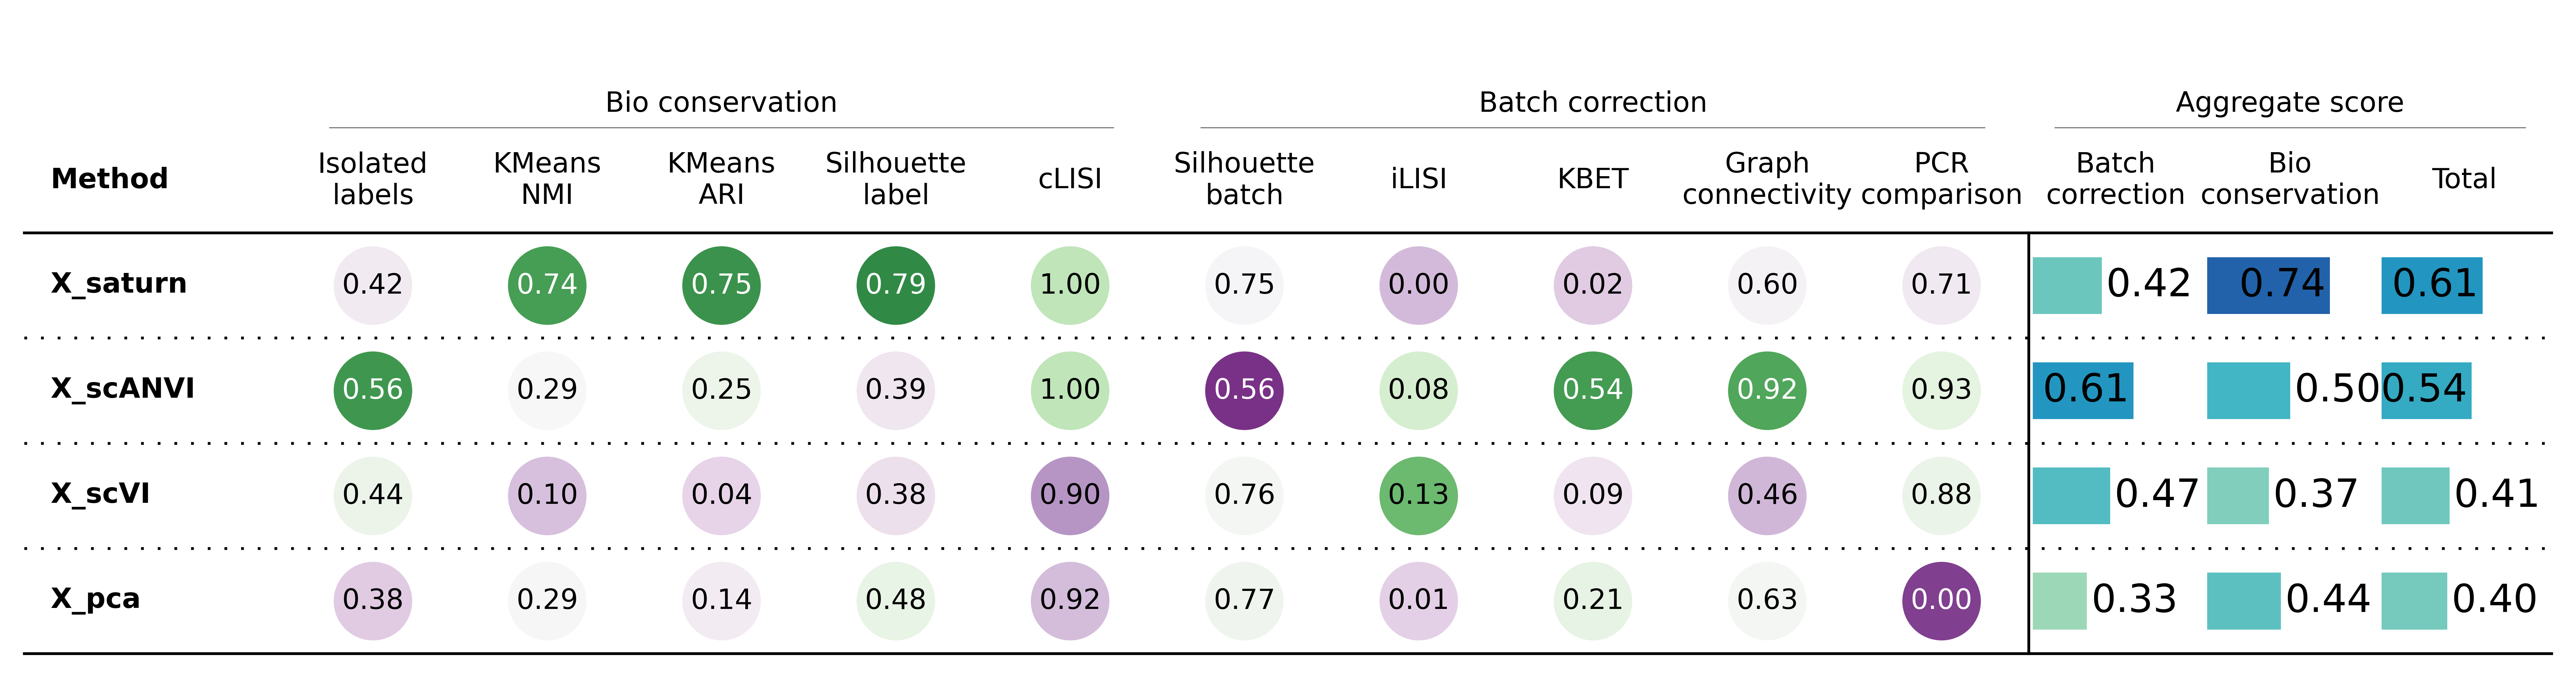

In [60]:
bm = Benchmarker(
    adata,
    batch_key='Library_Preparation_Protocol',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)

computing PCA
    with n_comps=50
    finished (0:00:02)


Embeddings: 100%|████████████████████████████████████████████████████| 4/4 [05:44<00:00, 86.09s/it]


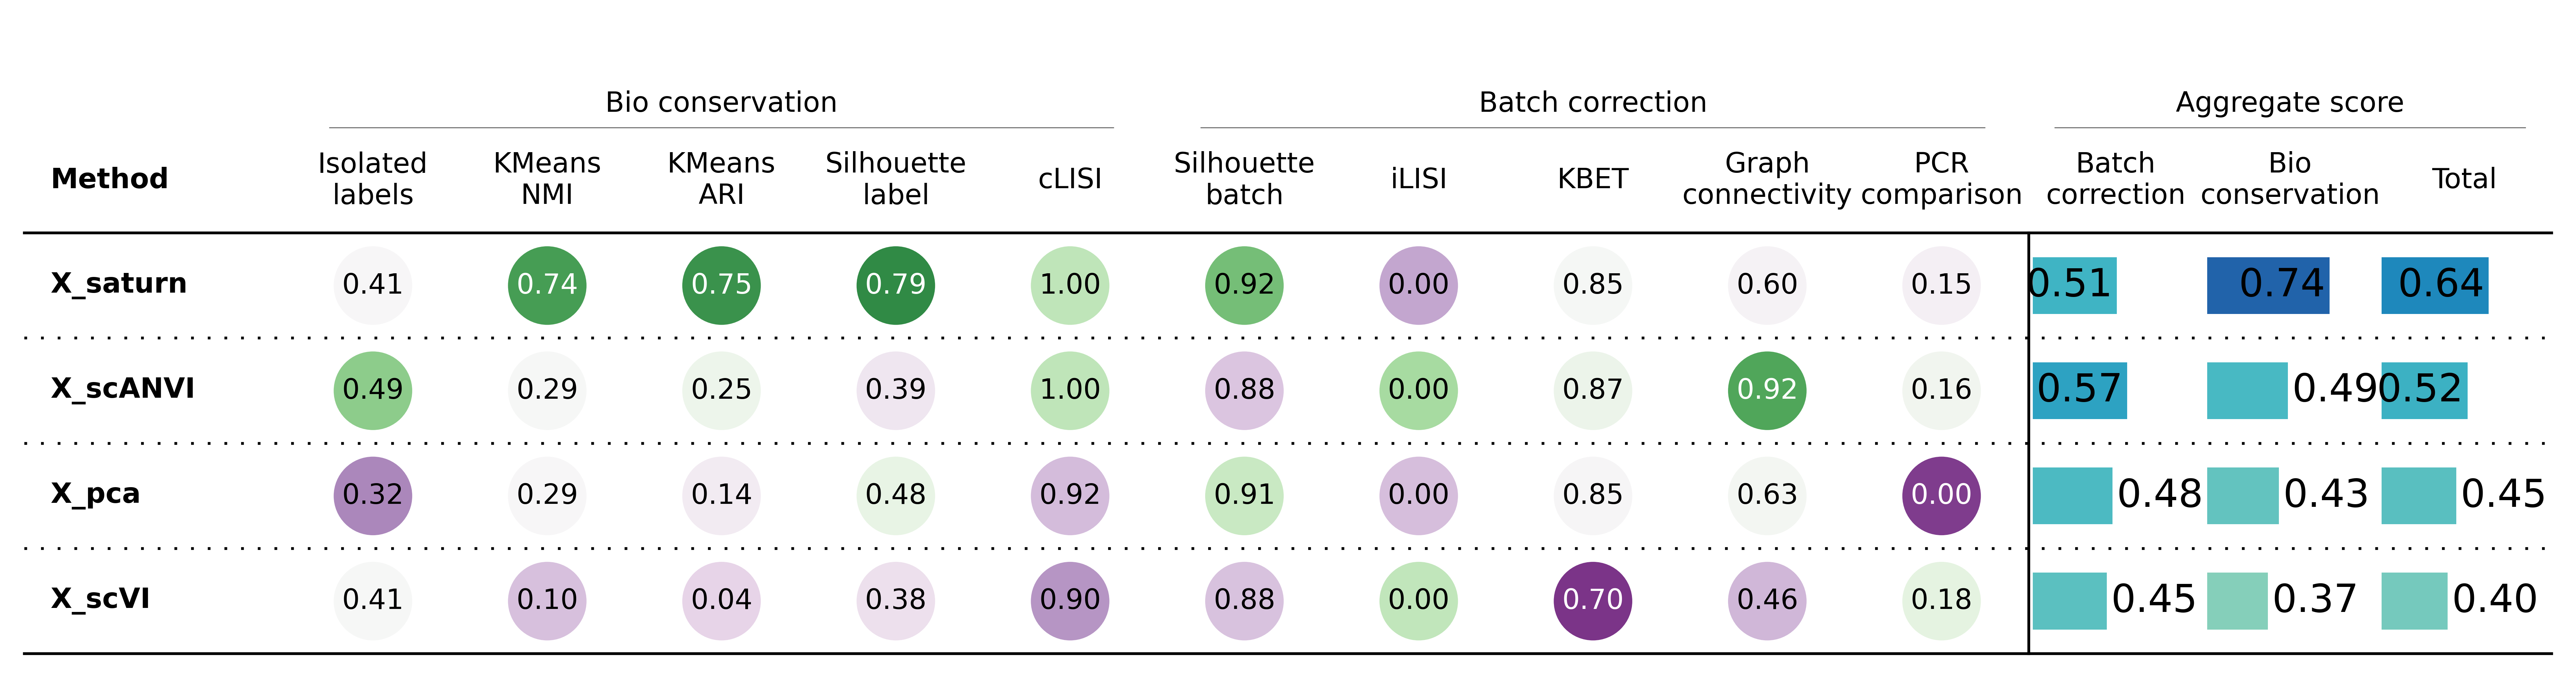

In [61]:
bm = Benchmarker(
    adata,
    batch_key='n_counts',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)

computing PCA
    with n_comps=50
    finished (0:00:02)


Embeddings: 100%|████████████████████████████████████████████████████| 4/4 [02:28<00:00, 37.18s/it]


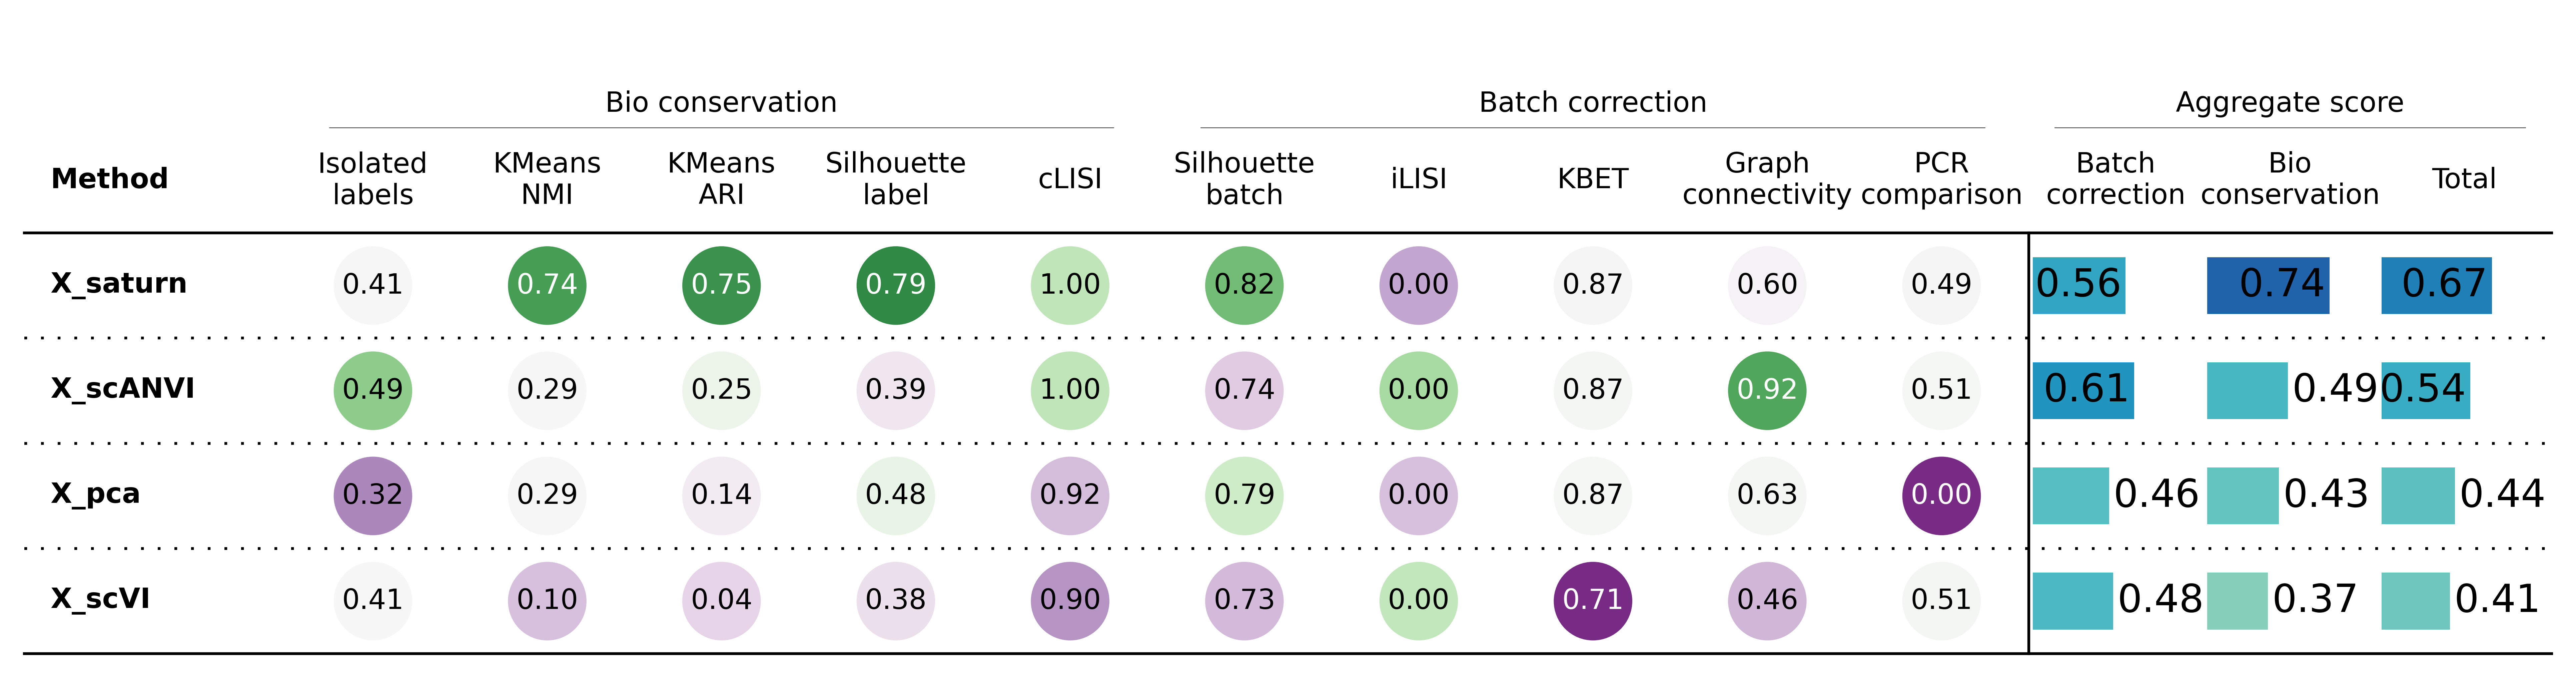

In [62]:
bm = Benchmarker(
    adata,
    batch_key='n_genes',
    label_key='cell_type',
    embedding_obsm_keys=['X_pca', 'X_scVI', 'X_scANVI', 'X_saturn'],
    n_jobs=-1
)

bm.benchmark()

bm.plot_results_table(min_max_scale=False)

In [63]:
adata

AnnData object with n_obs × n_vars = 8306 × 4922
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'cell_type', 'barcode', 'Gene_marker', 'GFP_intensity', 'full_cell_description', 'Sample', 'C_scANVI'
    var: 'feature_types-0-0-0-human', 'gene_name-1-0-0-human', 'gene_id-0-0-human', 'GENE-1-0-human', 'n_counts-human', 'n_cells-human', 'n_counts-mouse', 'n_cells-mouse', 'ensemble_gene_id_version-mouse', 'ensemble_gene_id-mouse', 'start_position-mouse', 'end_position-mouse', 'chromosome_name-mouse', 'external_gene_name-mouse', 'gene_name-mouse', 'Macrogene-mouse', 'Top Human Gen